In [94]:
# Build neural network

# read training data
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

#df = pd.Dataframe()
df_train = pd.read_csv('./measuring-customer-happiness/train_hp.csv', encoding='utf-8')
print(df_train.head(3))

#df_test = pd.read_csv('./measuring-customer-happiness/test_hp.csv', encoding='utf-8')
#print(df_test.head(3))

   User_ID  \
0  id10326   
1  id10327   
2  id10328   

                                                                                           Description  \
0  The room was kind of clean but had a VERY strong smell of dogs. Generally below average but ok f...   
1  I stayed at the Crown Plaza April -- - April --, ----. The staff was friendly and attentive. The...   
2  I booked this hotel through Hotwire at the lowest price I could find. When we got there the fron...   

        Browser_Used Device_Used Is_Response  
0               Edge      Mobile   not happy  
1  Internet Explorer      Mobile   not happy  
2            Mozilla      Tablet   not happy  


In [95]:
df_train = df_train[['Description', 'Is_Response']]
print(df_train.head())

                                                                                           Description  \
0  The room was kind of clean but had a VERY strong smell of dogs. Generally below average but ok f...   
1  I stayed at the Crown Plaza April -- - April --, ----. The staff was friendly and attentive. The...   
2  I booked this hotel through Hotwire at the lowest price I could find. When we got there the fron...   
3  Stayed here with husband and sons on the way to an Alaska Cruise. We all loved the hotel, great ...   
4  My girlfriends and I stayed here to celebrate our --th birthdays. We had planned this weekend ge...   

  Is_Response  
0   not happy  
1   not happy  
2   not happy  
3       happy  
4   not happy  


In [96]:
# select only rows with happy values and reduce happy values to same amount as not happy values
df_happy = df_train.loc[df_train['Is_Response'] == 'happy']
df_not_happy = df_train.loc[df_train['Is_Response'] == 'not happy']
print(df_happy)

                                                                                               Description  \
3      Stayed here with husband and sons on the way to an Alaska Cruise. We all loved the hotel, great ...   
5      We had - rooms. One was very nice and clearly had been updated more recently than the other. The...   
7      My wife & I stayed in this glorious city a while back. SF is expensive, but we found this little...   
8      My boyfriend and I stayed at the Fairmont on a recent trip to San Francisco. I could not recomme...   
10                           Steps off Times Square, nice rooms, stayed - nights, great for a short visit.   
11     Me, the Wife and - kids stayed here on Valentine's weekend ----. Really a nice hotel in a great ...   
13     I highly recommend the Hawthorne Terrace as an affordable, comfortable spot in Chicago. The staf...   
14     I found the hotel clean and nicely located. Good, free shuttle to the airport leaves twice per h...   
15     Sta

In [97]:
# only get the first 12411 rows of happy dataframe
df_happy = df_happy.head(12411)
print(df_happy)

                                                                                               Description  \
3      Stayed here with husband and sons on the way to an Alaska Cruise. We all loved the hotel, great ...   
5      We had - rooms. One was very nice and clearly had been updated more recently than the other. The...   
7      My wife & I stayed in this glorious city a while back. SF is expensive, but we found this little...   
8      My boyfriend and I stayed at the Fairmont on a recent trip to San Francisco. I could not recomme...   
10                           Steps off Times Square, nice rooms, stayed - nights, great for a short visit.   
11     Me, the Wife and - kids stayed here on Valentine's weekend ----. Really a nice hotel in a great ...   
13     I highly recommend the Hawthorne Terrace as an affordable, comfortable spot in Chicago. The staf...   
14     I found the hotel clean and nicely located. Good, free shuttle to the airport leaves twice per h...   
15     Sta

In [98]:
frames = [df_happy, df_not_happy]
df_train = pd.concat(frames)
print(df_train)

                                                                                               Description  \
3      Stayed here with husband and sons on the way to an Alaska Cruise. We all loved the hotel, great ...   
5      We had - rooms. One was very nice and clearly had been updated more recently than the other. The...   
7      My wife & I stayed in this glorious city a while back. SF is expensive, but we found this little...   
8      My boyfriend and I stayed at the Fairmont on a recent trip to San Francisco. I could not recomme...   
10                           Steps off Times Square, nice rooms, stayed - nights, great for a short visit.   
11     Me, the Wife and - kids stayed here on Valentine's weekend ----. Really a nice hotel in a great ...   
13     I highly recommend the Hawthorne Terrace as an affordable, comfortable spot in Chicago. The staf...   
14     I found the hotel clean and nicely located. Good, free shuttle to the airport leaves twice per h...   
15     Sta

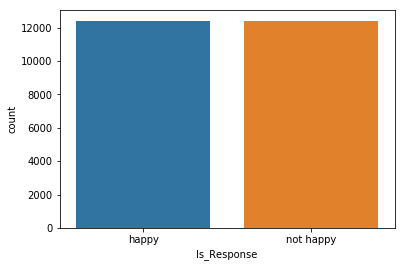

In [99]:
import seaborn as sns

sns.countplot(x='Is_Response', data=df_train)

In [100]:
# Data Preprocessing

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

X = []
sentences = list(df_train['Description'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [101]:
X[3]


'My boyfriend and stayed at the Fairmont on recent trip to San Francisco could not recommend this hotel more called the hotel few weeks before to order cake to be delivered to our room on our first night to celebrate my boyfriend birthday was immediately connected directly to the pastry chef who helped me to design the most delicious cake have ever eaten in my entire life The rooms are large and luxurious with wonderful old world feel Most importantly don miss dinner at the Tonga Room What fun restaurant Definitely order Scorpion Bowl but only if you re staying in the hotel they re strong '

In [102]:
# binary classification for happy and not_happy 

y = df_train['Is_Response']

y = np.array(list(map(lambda x: 1 if x=="happy" else 0, y)))

# 1) Simple Neural Network

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [104]:
# Prepare embedding layer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [105]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [106]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('./glove.twitter.27B/glove.twitter.27B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [107]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [108]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [109]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          3451700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 3,461,701
Trainable params: 10,001
Non-trainable params: 3,451,700
_________________________________________________________________
None


# Model training

In [110]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 15885 samples, validate on 3972 samples
Epoch 1/6
15885/15885 [==============================] - 1s 46us/step - loss: 0.5616 - acc: 0.7101 - val_loss: 0.5083 - val_acc: 0.7472
Epoch 2/6
15885/15885 [==============================] - 0s 30us/step - loss: 0.4278 - acc: 0.8069 - val_loss: 0.4871 - val_acc: 0.7633
Epoch 3/6
15885/15885 [==============================] - 1s 33us/step - loss: 0.3789 - acc: 0.8385 - val_loss: 0.5117 - val_acc: 0.7523
Epoch 4/6
15885/15885 [==============================] - 0s 17us/step - loss: 0.3487 - acc: 0.8530 - val_loss: 0.5232 - val_acc: 0.7510
Epoch 5/6
15885/15885 [==============================] - 0s 31us/step - loss: 0.3259 - acc: 0.8648 - val_loss: 0.5127 - val_acc: 0.7576
Epoch 6/6
15885/15885 [==============================] - 0s 16us/step - loss: 0.3034 - acc: 0.8780 - val_loss: 0.5233 - val_acc: 0.7538


# Evaluation of model 

In [111]:
score = model.evaluate(X_test, y_test, verbose=1)

4965/4965 [==============================] - 0s 14us/step


In [112]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5283154052369904
Test Accuracy: 0.7530715005035247


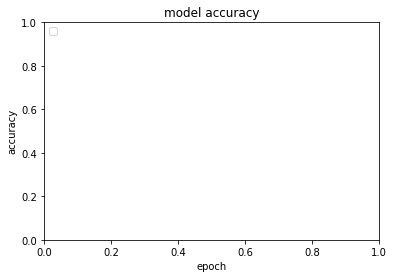

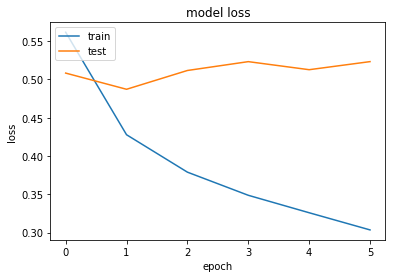

In [113]:
import matplotlib.pyplot as plt

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# 2) Convolutional Neural Network

In [114]:
from keras.layers.convolutional import Conv1D
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [115]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          3451700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,515,957
Trainable params: 64,257
Non-trainable params: 3,451,700
_________________________________________________________________
None


# Model Training & Evaluation 

In [116]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 15885 samples, validate on 3972 samples
Epoch 1/6
15885/15885 [==============================] - 9s 542us/step - loss: 0.5138 - acc: 0.7511 - val_loss: 0.4218 - val_acc: 0.8145
Epoch 2/6
15885/15885 [==============================] - 6s 366us/step - loss: 0.3803 - acc: 0.8369 - val_loss: 0.4504 - val_acc: 0.7893
Epoch 3/6
15885/15885 [==============================] - 8s 493us/step - loss: 0.3249 - acc: 0.8692 - val_loss: 0.3783 - val_acc: 0.8369
Epoch 4/6
15885/15885 [==============================] - 7s 436us/step - loss: 0.2852 - acc: 0.8896 - val_loss: 0.3716 - val_acc: 0.8366
Epoch 5/6
15885/15885 [==============================] - 8s 498us/step - loss: 0.2439 - acc: 0.9119 - val_loss: 0.3624 - val_acc: 0.8394
Epoch 6/6
4965/4965 [==============================] - 1s 153us/step


In [117]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print(score)

Test Score: 0.36961262136667755
Test Accuracy: 0.8360523665779667
[0.36961262136667755, 0.8360523665779667]


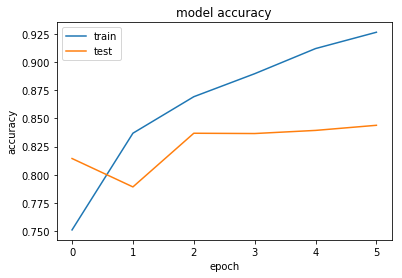

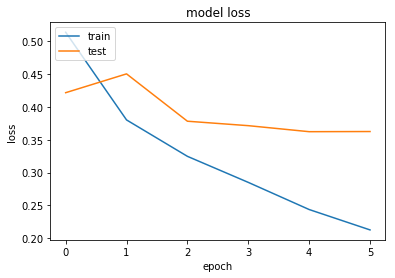

In [118]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# 3) Recurrent Neural Network: LSTM (Long Short Term Memory network)

In [119]:
from keras.layers.recurrent import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [120]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          3451700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 3,569,077
Trainable params: 117,377
Non-trainable params: 3,451,700
_________________________________________________________________
None


# Model Training & Evaluation 

In [121]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)


Train on 15885 samples, validate on 3972 samples
Epoch 1/10
15885/15885 [==============================] - 36s 2ms/step - loss: 0.5568 - acc: 0.7158 - val_loss: 0.5542 - val_acc: 0.7382
Epoch 2/10
15885/15885 [==============================] - 36s 2ms/step - loss: 0.4579 - acc: 0.7948 - val_loss: 0.4460 - val_acc: 0.7822
Epoch 3/10
15885/15885 [==============================] - 26s 2ms/step - loss: 0.4265 - acc: 0.8106 - val_loss: 0.4234 - val_acc: 0.8016
Epoch 4/10
15885/15885 [==============================] - 25s 2ms/step - loss: 0.4026 - acc: 0.8208 - val_loss: 0.3940 - val_acc: 0.8220
Epoch 5/10
15885/15885 [==============================] - 35s 2ms/step - loss: 0.3933 - acc: 0.8314 - val_loss: 0.3955 - val_acc: 0.8280
Epoch 6/10
15885/15885 [==============================] - 31s 2ms/step - loss: 0.3715 - acc: 0.8384 - val_loss: 0.4148 - val_acc: 0.8192
Epoch 7/10
15885/15885 [==============================] - 40s 3ms/step - loss: 0.3669 - acc: 0.8413 - val_loss: 0.3798 - val_acc:

In [122]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3831261041541354
Test Accuracy: 0.8324269889224571


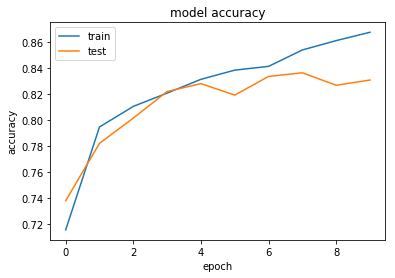

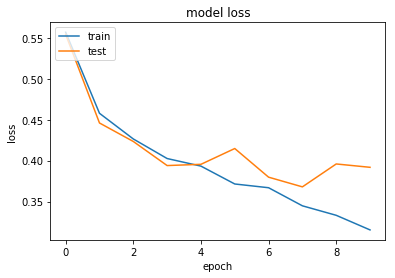

In [123]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


# Load facebook comments

In [124]:
import json
import requests
import pandas as pd
import datetime

class FacebookApi:

    ## below facebook api call


    def callFacebookApi(self):
        
        url_long = "https://graph.facebook.com/v5.0/me?fields=id%2Cname%2Cposts%7Bcomments%7D&access_token=EAAlcIv35CUUBANREEygggKozZBFTNubNFhwuDn0u3MDI1jHz4PYRGirDFxz7MoSMTz3AHu6ZCQdT0oBp0cM3a30fGzw1pfb27C6H5OGn5jxiV49TqK8yaBiZA6DKZAeR3r0yzGGFFMGZAGmf6lMDeh8elMMGFZA5z4pk8KfQ2uiDZAZB67gt1nfh"

        response = requests.get(url_long)
        json_data = json.loads(response.text)
        #df = pd.DataFrame(columns=['comment', 'person', 'time'])
        dictFb = {'comment': [], 'person':[], 'time':[]}
        for i in range(len(json_data['posts']['data'])-1):
            dictFb['comment'].append(json_data['posts']['data'][i]['comments']['data'][i]['message'])
            dictFb['person'].append(json_data['posts']['data'][i]['comments']['data'][i]['from']['name'])
            dictFb['time'].append(json_data['posts']['data'][i]['comments']['data'][i]['created_time'])
            #df.append({'comment': comment, 'person':person, 'time':time}, ignore_index=True)
        df = pd.DataFrame(dictFb,columns=['comment', 'person', 'time'])

        return df
    

In [125]:
fb =FacebookApi()
fb.callFacebookApi()
print(fb.callFacebookApi())

                      comment            person                      time
0  second comment 456 negativ  Lachmann Cruises  2019-12-06T18:59:43+0000


In [126]:
import json
import requests
import datetime

url_long = "https://graph.facebook.com/v5.0/me?fields=id%2Cname%2Cposts%7Bcomments%7D&access_token=EAAlcIv35CUUBANREEygggKozZBFTNubNFhwuDn0u3MDI1jHz4PYRGirDFxz7MoSMTz3AHu6ZCQdT0oBp0cM3a30fGzw1pfb27C6H5OGn5jxiV49TqK8yaBiZA6DKZAeR3r0yzGGFFMGZAGmf6lMDeh8elMMGFZA5z4pk8KfQ2uiDZAZB67gt1nfh"

response = requests.get(url_long)
json_data = json.loads(response.text)
comment = json_data['posts']['data'][0]['comments']['data'][0]['message']
person = json_data['posts']['data'][0]['comments']['data'][0]['from']['name']
time = json_data['posts']['data'][0]['comments']['data'][0]['created_time']

print(comment)
print(person)
print(time)


#for i in posts['data']:
 #   message = i['message']
  #  print(message)

second comment 456 negativ
Lachmann Cruises
2019-12-06T18:59:43+0000


# Load facebook comments

# Predict sentiments

In [127]:
instance = X[57]

print(instance)


We travel for work and m constantly looking for new and intersting places to stay The Inn at The Black Olive was perfect didn feel like was stuck in another hotel but rather staying somewhere fun and relaxing The location was amazing and the beds are really comfortable The restaurant upstairs was excellent Everyone was really nice and helpful only had few thoughts that weren totally positive but they in no way will keep me from staying there every time we re in Baltimore for work The TV in the living room was on the smaller side As don watch TV lot that doesn really matter to me There was no dock or stereo hookup for an ipod Would have been nice but again wasn there to just sit in the room for hours They only carried glass bottles for water get why for sure but it would have been nice to have something more easy to carry outside the hotel Maybe have water bottles in the room that they can charge for 


####  - convert review into numeric form (using the tokenizer)
####  - text_to_sequences method will convert the sentence into its numeric counter part
####  - positive = 1, negative = 0
####  - sigmoid function predicts floating value between 0 and 1. 
####  - value < 0.5 = negative sentiment 
####  - value > 0.5 = positive sentiment 


In [142]:
import pandas as pd

df_test = pd.read_csv('./measuring-customer-happiness/test_hp.csv', encoding='utf-8')
df_test = df_test['Description']
pd.set_option('display.max_colwidth', 100)
df_test.head()
i=0
for x in df_test:    
    instance = X[i]
    ++i
    print(instance)
    
instance = X[df_test[1]]
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

Stayed here with husband and sons on the way to an Alaska Cruise We all loved the hotel great experience Ask for room on the North tower facing north west for the best views We had high floor with stunning view of the needle the city and even the cruise ships We ordered room service for dinner so we could enjoy the perfect views Room service dinners were delicious too You are in perfect spot to walk everywhere so enjoy the city Almost forgot Heavenly beds were heavenly too 
Stayed here with husband and sons on the way to an Alaska Cruise We all loved the hotel great experience Ask for room on the North tower facing north west for the best views We had high floor with stunning view of the needle the city and even the cruise ships We ordered room service for dinner so we could enjoy the perfect views Room service dinners were delicious too You are in perfect spot to walk everywhere so enjoy the city Almost forgot Heavenly beds were heavenly too 
Stayed here with husband and sons on the w

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



array([[0.6083274]], dtype=float32)

In [135]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

    flat_list = [flat_list]

    instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

    model.predict(instance)
    
instance = X[57]

print(instance)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [130]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.57856214]], dtype=float32)

# Send email

In [131]:
import smtplib, ssl

port = 587  # For starttls
smtp_server = "smtp.gmail.com"
receiver_email = "burghard.lachmann+kunde@gmail.com"
sender_email = "burghard.lachmann@gmail.com"
password = 'Brunhilde'
message = """
Report von HH Analytica
"""

context = ssl.create_default_context()
with smtplib.SMTP(smtp_server, port) as server:
   # server.ehlo()  # Can be omitted
    server.starttls(context=context)
    #server.ehlo()  # Can be omitted
    server.login(sender_email, password)
    server.sendmail(sender_email, receiver_email, message)

In [132]:
from smtplib import SMTP
with SMTP("https://www.web.de") as smtp:
    smtp.noop()

OSError: nonnumeric port